<a href="https://colab.research.google.com/github/Sandipan234/Stock_predictor/blob/main/Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable 


In [250]:
#seting up training inputs

input_train=pd.read_csv('https://raw.githubusercontent.com/Sandipan234/Stock_predictor/104c3327a9e2a99c7ea4036a5ac85e57cacf06e5/HDFCBANK_TRAIN2.csv')
input_test=pd.read_csv('https://raw.githubusercontent.com/Sandipan234/Stock_predictor/104c3327a9e2a99c7ea4036a5ac85e57cacf06e5/HDFCBANK_TEST2.csv')
# input_train.head(10)
train_set=input_train.iloc[:,4:5]
test_set=input_test.iloc[:,4:5]
train_set.head()

,Close
0,934.075012
1,934.150024
2,938.325012
3,934.174988
4,928.375000


In [ ]:
date=(input_train['Date'])
date1=date.str.replace("-","").astype(float)
date2=date1.to_numpy()
date_set=np.reshape(date2,(739,1))
print(date_set)


In [ ]:
dateT=(input_test['Date'])
dateT1=dateT.str.replace("-","").astype(float)
dateT2=dateT1.to_numpy()
dateT_set=np.reshape(dateT2,(246,1))
print(dateT_set)

In [ ]:
#Scaling the Data

from sklearn.preprocessing import MinMaxScaler,StandardScaler
mmscale=MinMaxScaler()
stdscale=StandardScaler()
train_setx_scaled=stdscale.fit_transform(train_set)
test_setx_scaled=stdscale.fit_transform(test_set)
date_scaled=mmscale.fit_transform(date_set)
dateT_scaled=mmscale.fit_transform(dateT_set)
# train_sety_scaled=scale.fit_transform(date_train)
print(train_setx_scaled)

In [254]:
#seting up the the inputs for training

from os import X_OK
x_train=[]
x_test=[]
date_train=[]
date_test=[]
for i in range(5,740):
  x_train.append(train_setx_scaled[i-5:i,0])
  date_train.append(date_scaled[i-5:i,0])
for i in range(5,247):
  x_test.append(train_setx_scaled[i-5:i,0])
  date_test.append(date_scaled[i-5:i,0])
#changing the inputs array to tensor
x_train_tensors = Variable(torch.Tensor(x_train))
# x_test_tensors = Variable(torch.Tensor(x_test))


In [255]:
#converting to tensors for feeding
x_train_tensors = Variable(torch.Tensor(x_train))
x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
print("Training Shape", x_train_tensors_final.shape)


x_test_tensors = Variable(torch.Tensor(x_test))
x_test_tensors_final = torch.reshape(x_test_tensors,   (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))
print("Testing Shape", x_test_tensors_final.shape)



date_train_tensors = Variable(torch.Tensor(date_train))
date_train_tensors_final = torch.reshape(date_train_tensors,   (date_train_tensors.shape[0], 1, date_train_tensors.shape[1]))
print("Training date Shape", date_train_tensors_final.shape)


date_test_tensors = Variable(torch.Tensor(date_test))
date_test_tensors_final = torch.reshape(date_test_tensors,   (date_test_tensors.shape[0], 1, date_test_tensors.shape[1]))
# date_test_tensors_final=date_test_tensors_final.reshape([246,1,1])
print("Testing Shape", date_test_tensors_final.shape)




Training Shape torch.Size([735, 1, 5])
Testing Shape torch.Size([242, 1, 5])
Training date Shape torch.Size([735, 1, 5])
Testing Shape torch.Size([242, 1, 5])


In [256]:
#Creating the Neural Network Structure
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [257]:
#creating feeding variables
num_epochs = 10000
learning_rate = 0.0001
input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

In [258]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1]) #instanting th lstm class 

In [259]:
#defining the loss function and optimizer
criterion = torch.nn.MSELoss() #using MeanSquared Loss function for loss detection
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #using adam for optimising the weights


In [ ]:
#Training the NeuralNetwork
for epoch in range(num_epochs):
  outputs = lstm.forward(x_train_tensors_final) #forward passing
  optimizer.zero_grad() #caluclating the gradient, manually setting to 0
 
  # obtaining the loss function
  loss = criterion(outputs, date_train_tensors)
 
  loss.backward() #calculating the loss of the loss function
 
  optimizer.step() #improving from loss
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
#predicitng the future stock
prediction = lstm(x_test_tensors_final)
predicted_price=(prediction.data.numpy())
final_x = x_test_tensors_final.data.numpy()

predicted_price=mmscale.inverse_transform(predicted_price)
final_date=dateT2
print(predicted_price)

<function matplotlib.pyplot.show(*args, **kw)>

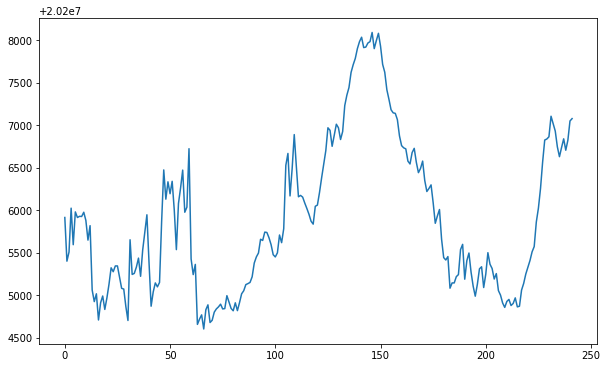

In [263]:
#Plotting the result

plt.figure(figsize=(10,6))

#
plt.plot(predicted_price,label='Predicted Data')

plt.show

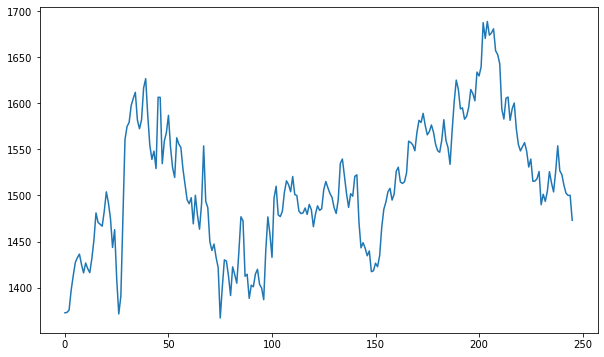

In [245]:
plt.figure(figsize=(10,6))
plt.plot(test_set, label='Actuall Data')